<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2006%20-%20Customer%20Segmentation/clustering-result-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation - Clustering Result EDA

**Subject:** BADS 7105 - CRM Analytics and Intelligence  
**Student:** Tanat Iempreedee (6210422036)

# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# from google.colab import auth
# auth.authenticate_user()

%cd "/content/drive/My Drive/BADS/7105 CRM/work/06 - Customer Segmentation"
%ls

[Errno 2] No such file or directory: '/content/drive/My Drive/BADS/7105 CRM/work/06 - Customer Segmentation'
/content
adc.json  dtree.jpg  onetime_clusters.csv  repeat_clusters.csv  sample_data/


# Read from BigQuery

In [2]:
from google.colab import auth
auth.authenticate_user()

In [4]:
project_id = 'tanat-project'

onetime_clusters = pd.io.gbq.read_gbq(f'''
SELECT  
    * except(nearest_centroids_distance)
from ml.predict(model `tanat-project.supermarket.onetime_clusters`, (
    SELECT 
        cust_code, total_spend, days_since_last_purch
    FROM `tanat-project.supermarket.customers`
    WHERE total_visit = 1
))
''', project_id=project_id)
print(f'One-time clusters: {onetime_clusters.shape}')
onetime_clusters.to_csv('onetime_clusters.csv', index=False)

repeat_clusters = pd.io.gbq.read_gbq(f'''
SELECT
    * EXCEPT(nearest_centroids_distance)
FROM ML.PREDICT(MODEL `tanat-project.supermarket.repeat_clusters`, (
    SELECT 
        avg_ticket_size,
        avg_monthly_visit, avg_monthly_spend,
        days_since_last_purch, days_since_first_purch, avg_time_to_event,
    FROM `tanat-project.supermarket.customers`
    WHERE total_visit > 1
))
''', project_id=project_id)
print(f'Repeat-purchase Clusters: {repeat_clusters.shape}')
repeat_clusters.to_csv('repeat_clusters.csv', index=False)

One-time clusters: (2025, 4)
Repeat-purchase Clusters: (4075, 7)


# Single-Purchase Customer Segments

Segmets of customers who only have a single transaction.

In [15]:
onetime_clusters = pd.read_csv('onetime_clusters.csv')
print(onetime_clusters.shape)
onetime_clusters.head()

(2025, 4)


,CENTROID_ID,cust_code,total_spend,days_since_last_purch
0,2,CUST0000506599,34.32,714
1,4,CUST0000228766,1.17,481
2,4,CUST0000785097,2.51,798
3,4,CUST0000515625,2.81,656
4,4,CUST0000592286,1.11,643


In [11]:
onetime_clusters.CENTROID_ID.value_counts(sort=False)

1    933
2    160
3     63
4    869
Name: CENTROID_ID, dtype: int64

In [134]:
onetime_clusters.groupby('CENTROID_ID').describe()

total_spend                        ... days_since_last_purch               
                  count       mean        std  ...                   50%     75%    max
CENTROID_ID                                    ...                                     
1                 933.0   4.696517   5.583235  ...                 268.0  353.00  462.0
2                 160.0  30.373500   8.757825  ...                 617.5  714.25  817.0
3                  63.0  69.961111  26.469416  ...                 314.0  513.50  748.0
4                 869.0   3.825259   3.952459  ...                 656.0  725.00  818.0

[4 rows x 16 columns]

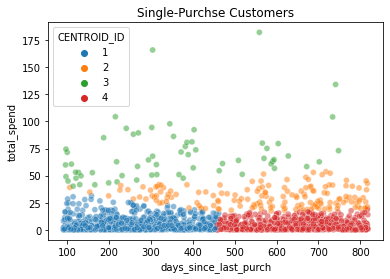

In [98]:
palette = 'tab10'
sns.scatterplot(data=onetime_clusters ,x='days_since_last_purch',y='total_spend',hue='CENTROID_ID',alpha=.5, palette=palette)
plt.title('Single-Purchse Customers')
plt.show()

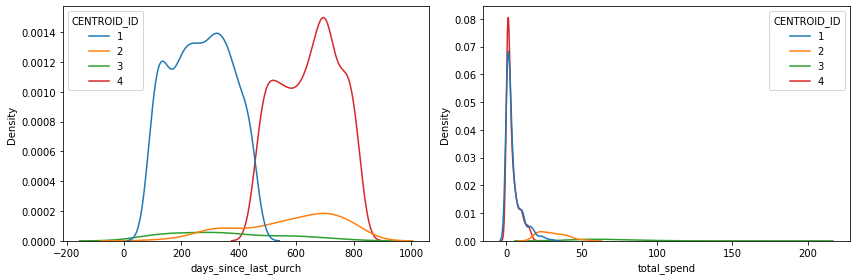

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), tight_layout=True)
sns.kdeplot(data=onetime_clusters, x='days_since_last_purch', hue='CENTROID_ID', palette=palette, ax=axes[0])
sns.kdeplot(data=onetime_clusters, x='total_spend', hue='CENTROID_ID', palette=palette, ax=axes[1])
plt.show()

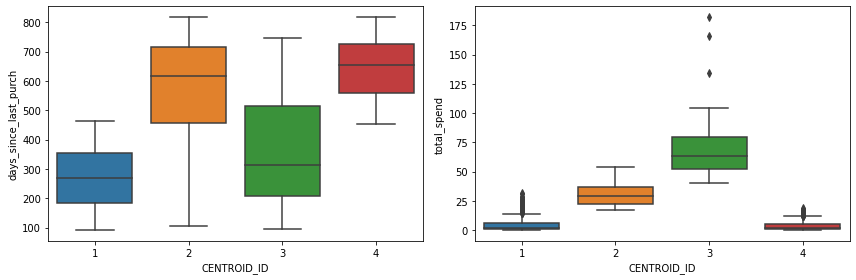

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), tight_layout=True)
sns.boxplot(data=onetime_clusters, y='days_since_last_purch', x='CENTROID_ID', palette=palette, ax=axes[0])
sns.boxplot(data=onetime_clusters, y='total_spend', x='CENTROID_ID', palette=palette,ax=axes[1])
plt.show()

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = onetime_clusters[['total_spend','days_since_last_purch']]
y = onetime_clusters['CENTROID_ID']
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
fimp = pd.DataFrame({'feature': X.columns, 'importance' : clf.feature_importances_}).set_index('feature')
fimp.sort_values('importance', ascending=False)

,importance
feature,
days_since_last_purch,0.679619
total_spend,0.320381


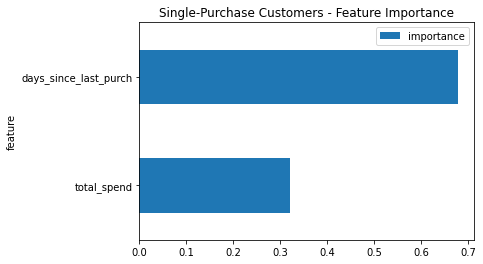

In [18]:
fimp.sort_values('importance').plot.barh(title='Single-Purchase Customers - Feature Importance');

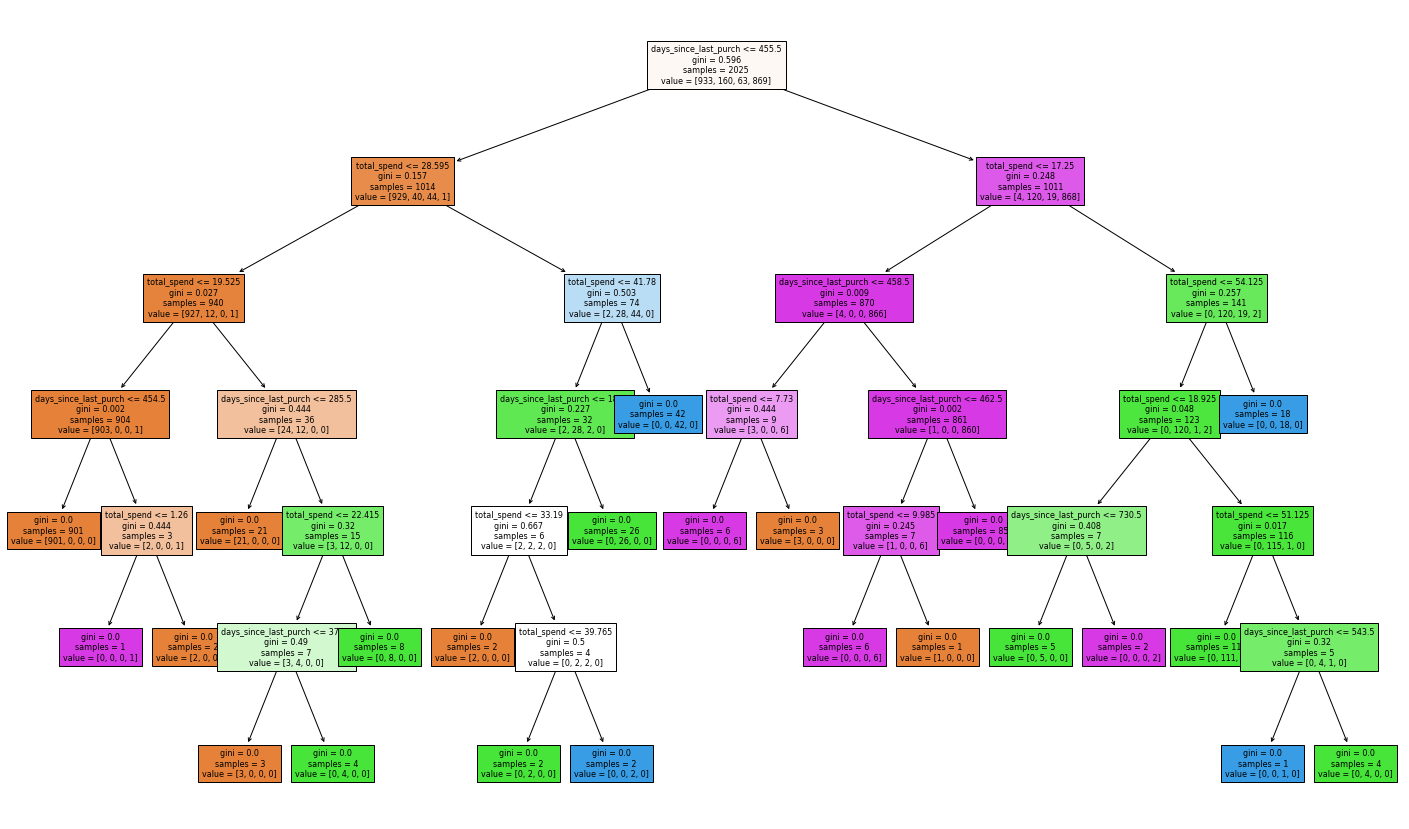

In [101]:
plt.figure(figsize=(25,15))
plot_tree(clf, feature_names=X.columns, filled=True, fontsize=8)

plt.savefig('dtree.jpg', dpi=120)
plt.show()

## Repeat-Purchase Customer Segments

In [24]:
repeat_clusters = pd.read_csv('repeat_clusters.csv')

fields = ['CENTROID_ID','avg_ticket_size','avg_monthly_spend','avg_monthly_visit','days_since_last_purch','days_since_first_purch','avg_time_to_event']
repeat_clusters = repeat_clusters[fields]
print(repeat_clusters.shape)
repeat_clusters.head()

(4075, 7)


,CENTROID_ID,avg_ticket_size,avg_monthly_spend,avg_monthly_visit,days_since_last_purch,days_since_first_purch,avg_time_to_event
0,3,6.561333,8.201667,1.250000,42,767,51.785714
1,4,0.630000,0.630000,1.000000,233,464,231.000000
2,6,2.110000,2.110000,1.000000,43,236,193.000000
3,6,22.130000,22.130000,1.000000,51,360,103.000000
4,3,4.615444,15.384815,3.333333,3,810,9.067416


In [25]:
repeat_clusters.CENTROID_ID.value_counts().sort_index()

1     400
2     160
3    1854
4     538
5     334
6     789
Name: CENTROID_ID, dtype: int64

In [26]:
from IPython.display import HTML

desc = repeat_clusters.groupby('CENTROID_ID').describe()
for col in repeat_clusters.columns[1:]:
    display(HTML(f"<h3>{col.upper()}</h3>"))
    display(desc[col].style.bar(color='turquoise'))
    display(HTML('<hr/>'))

,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,36.550894,19.348500,16.390984,26.610125,32.987167,41.823638,306.970000
2,160.000000,6.225875,8.794832,0.010000,1.087500,2.610000,7.023750,43.830000
3,1854.000000,8.358349,6.068056,0.035000,3.437407,6.981166,12.214432,31.655000
4,538.000000,6.321273,6.735365,0.080000,1.422500,3.535000,8.956875,31.670000
5,334.000000,12.925935,7.025665,1.995433,7.149710,11.827542,17.540482,35.901964
6,789.000000,7.412264,7.065661,0.010000,2.060000,4.851786,10.898000,35.700000


,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,64.118079,33.330018,25.622500,42.572500,55.443030,76.506000,306.970000
2,160.000000,6.225875,8.794832,0.010000,1.087500,2.610000,7.023750,43.830000
3,1854.000000,14.223766,11.335428,0.035000,4.968750,11.522500,20.706375,61.470000
4,538.000000,6.794752,7.355699,0.080000,1.532500,3.582500,9.473750,39.115000
5,334.000000,88.049288,55.529475,13.768125,51.600982,74.828214,115.454881,535.646786
6,789.000000,11.474402,12.067233,0.010000,2.510000,6.900000,17.280000,84.461429


,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,1.857192,0.805106,1.000000,1.200000,1.600000,2.333333,4.222222
2,160.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1854.000000,1.717829,0.839753,1.000000,1.142857,1.444444,2.000000,5.800000
4,538.000000,1.063259,0.161614,1.000000,1.000000,1.000000,1.000000,2.000000
5,334.000000,7.443856,3.554871,3.384615,4.842963,6.125000,9.276786,23.785714
6,789.000000,1.530298,0.804857,1.000000,1.000000,1.250000,1.900000,7.750000


,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,77.600000,127.572438,0.000000,9.000000,30.000000,75.000000,812.000000
2,160.000000,79.600000,76.525919,0.000000,27.000000,50.000000,98.750000,346.000000
3,1854.000000,179.095469,234.523492,0.000000,13.250000,47.000000,320.750000,817.000000
4,538.000000,131.910781,129.994913,0.000000,34.000000,74.000000,219.500000,527.000000
5,334.000000,6.622754,18.143941,0.000000,1.000000,3.000000,7.000000,294.000000
6,789.000000,136.595691,120.553840,0.000000,41.000000,94.000000,212.000000,480.000000


,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,665.877500,168.736355,142.000000,586.250000,719.500000,802.000000,818.000000
2,160.000000,686.556250,86.551817,467.000000,631.750000,688.500000,758.250000,818.000000
3,1854.000000,730.368393,80.178179,473.000000,676.000000,754.000000,799.000000,818.000000
4,538.000000,608.057621,130.535348,313.000000,520.000000,617.000000,714.000000,818.000000
5,334.000000,783.673653,100.239884,153.000000,809.000000,815.000000,817.000000,818.000000
6,789.000000,322.366286,112.806048,92.000000,236.000000,321.000000,419.000000,548.000000


,count,mean,std,min,25%,50%,75%,max
CENTROID_ID,,,,,,,,
1,400.000000,74.466710,98.296979,2.000000,15.418269,36.204545,86.083333,609.000000
2,160.000000,606.956250,97.301215,450.000000,525.750000,595.500000,682.750000,805.000000
3,1854.000000,59.414994,46.617802,0.000000,20.910985,47.278846,87.312500,278.000000
4,538.000000,269.326208,79.328947,114.600000,204.625000,263.500000,330.375000,452.000000
5,334.000000,5.333042,3.328219,1.200000,3.235481,4.945122,6.487079,36.181818
6,789.000000,63.628615,55.341715,0.000000,18.600000,48.000000,96.250000,261.000000


In [27]:
X = repeat_clusters.iloc[:,1:]
y = repeat_clusters['CENTROID_ID']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


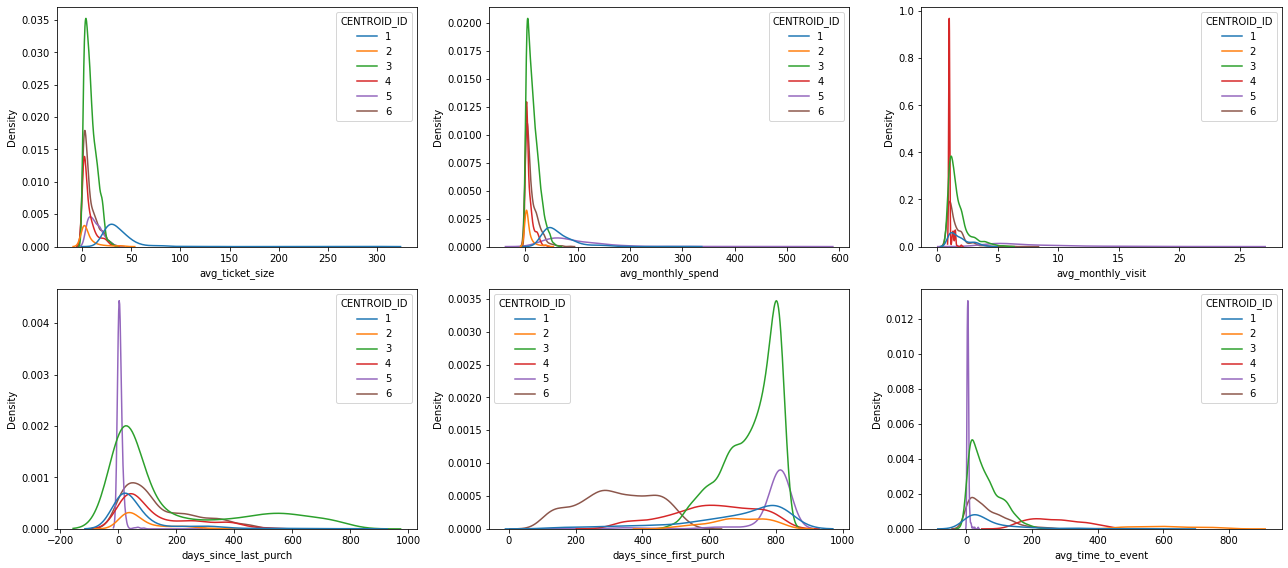

In [31]:
palette = 'tab10'
fig, axes = plt.subplots(2,3, figsize=(18,8), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(repeat_clusters.iloc[:,1:].columns, axes):
    sns.kdeplot(data=repeat_clusters, x=col, hue='CENTROID_ID', palette=palette, ax=ax)
plt.show()

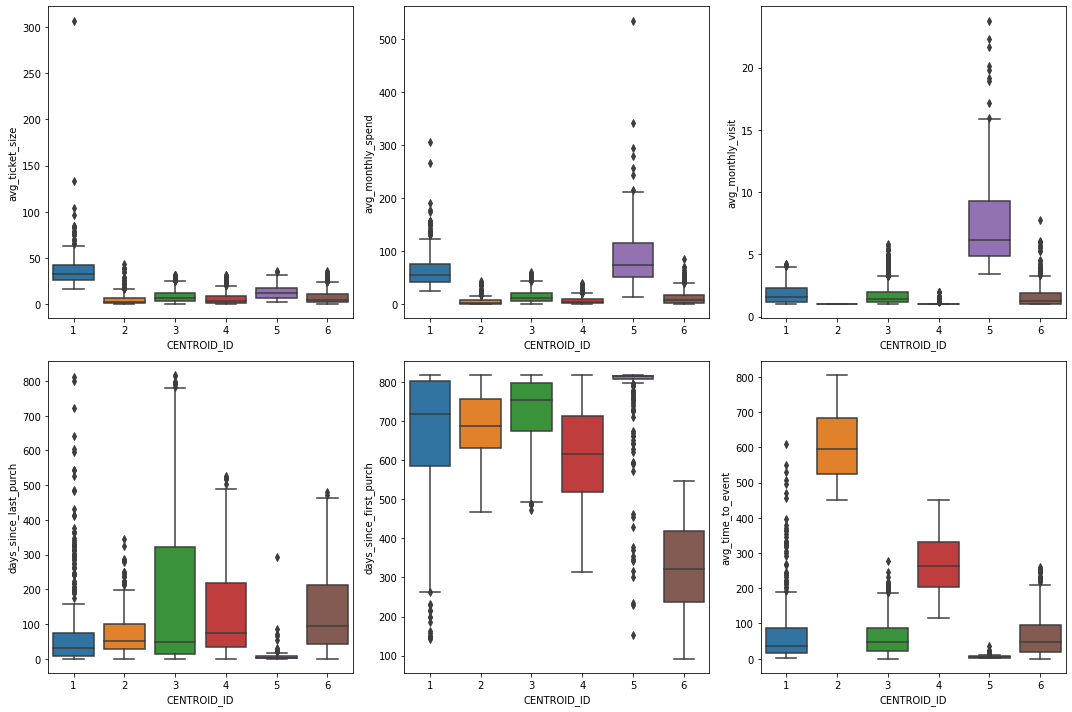

In [32]:
fig, axes = plt.subplots(2,3, figsize=(15,10), tight_layout=True)
axes = axes.ravel()
for col, ax in zip(repeat_clusters.iloc[:,1:].columns, axes):
    sns.boxplot(data=repeat_clusters, y=col, x='CENTROID_ID', palette=palette, ax=ax)
plt.show()

In [145]:
from sklearn.ensemble import RandomForestClassifier

X = repeat_clusters[['avg_ticket_size','avg_monthly_spend','avg_monthly_visit',
                       'days_since_first_purch','days_since_last_purch','avg_time_to_event']]
y = repeat_clusters['CENTROID_ID'] 

X_std = scale(X)

clf = RandomForestClassifier(criterion = 'entropy', random_state = 42)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [164]:
fimp = pd.DataFrame({'feature': X.columns, 'importance' : clf.feature_importances_}).set_index('feature')
fimp.sort_values('importance', ascending=False)

,importance
feature,
avg_time_to_event,0.291278
days_since_first_purch,0.286663
avg_monthly_spend,0.155968
avg_monthly_visit,0.115485
avg_ticket_size,0.108978
days_since_last_purch,0.041628


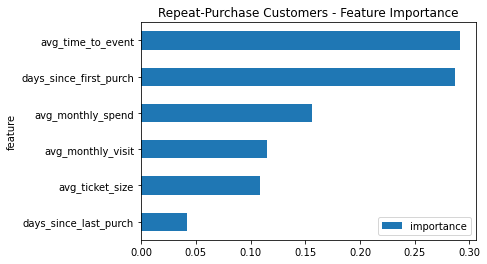

In [168]:
fimp.sort_values('importance').plot.barh(title='Repeat-Purchase Customers - Feature Importance');